In [ ]:
# Classifying business

## Importing labelled data

I parse 'labeled_firms_single' file in two dictionaries. One links the ciks to the catogories, the other links the categories to the ciks.

In [28]:
# These are the modules I use, If you use Anaconda, they should be installed on your system.
from collections import defaultdict
import glob
import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Here I open the 'labeled_firms_single.txt' file and creat a list called 'lines' from it, each element is a line of the file
with open('labeled_firms_single.txt', 'r') as f:
    lines = f.read().split('\n')[1:]
#From this list I create two maps : one maps one cik to the list of categories it beloings to
#the other maps the categories to the list of cik belonging to that category
#We also put the year (1998 or 1999) in the mapped elements, in order to know in which folder to look for the file.
cik2year_category = defaultdict(list)
category2year_cik = defaultdict(list)
for l in [l for l in lines if l]:
    _,cik,_,year,category = l.split('\t')
    category = int(category[2:-2])
    year = int(year)
    cik = int(cik)
    cik2year_category[cik].append([year, category])
    category2year_cik[category].append([year, cik])

#Here we sort the categories by the number of companies that belong to it, in order to study the categories with the most samples
categories = list(category2year_cik.keys())
def nb_items(cat):
    return len(category2year_cik[cat])
categories.sort(key=nb_items)


#This will display the number of examples we have for each category
[[c,nb_items(c)] for c in categories]

[[513, 1],
 [520, 1],
 [526, 1],
 [17, 1],
 [552, 1],
 [560, 1],
 [563, 1],
 [569, 1],
 [101, 1],
 [609, 1],
 [620, 1],
 [860, 1],
 [171, 1],
 [173, 1],
 [703, 1],
 [801, 1],
 [729, 1],
 [228, 1],
 [236, 1],
 [790, 1],
 [800, 1],
 [833, 1],
 [325, 1],
 [326, 1],
 [336, 1],
 [343, 1],
 [360, 1],
 [411, 1],
 [472, 1],
 [482, 1],
 [503, 1],
 [13, 2],
 [527, 2],
 [25, 2],
 [554, 2],
 [555, 2],
 [556, 2],
 [572, 2],
 [72, 2],
 [102, 2],
 [872, 2],
 [140, 2],
 [142, 2],
 [793, 2],
 [154, 2],
 [109, 2],
 [210, 2],
 [723, 2],
 [227, 2],
 [229, 2],
 [750, 2],
 [240, 2],
 [242, 2],
 [259, 2],
 [261, 2],
 [276, 2],
 [279, 2],
 [802, 2],
 [804, 2],
 [821, 2],
 [316, 2],
 [317, 2],
 [324, 2],
 [332, 2],
 [348, 2],
 [351, 2],
 [207, 2],
 [323, 2],
 [410, 2],
 [525, 2],
 [442, 2],
 [444, 2],
 [449, 2],
 [461, 2],
 [470, 2],
 [474, 2],
 [784, 2],
 [551, 3],
 [616, 3],
 [590, 3],
 [593, 3],
 [619, 3],
 [122, 3],
 [636, 3],
 [160, 3],
 [179, 3],
 [221, 3],
 [734, 3],
 [751, 3],
 [753, 3],
 [782, 3],
 [3

## Easiest possible classification task

### Principle
We will begin simple, and get fancy after if need be. I will use the go-to features for text classification : the tf-idf transform.

As for the task, I will take the one with the highest chance of success : I will select one of the categories with the most examples (category $C$), and use all the samples of that category. In this context, one 'sample' means one text file containing the description of one company. Let's say there are $N$ samples for category $C$.

Then, I'll select $N$ more samples from various other categories other than $C$. 

I will try to train the classifier so that it learns if something is in $C$ or not. This is known as the one-vs-all method.

If this works, it means there is hope that, with enough labelled data, one can recognize the category of a company. This would require training as many classifier as there are companies, but this is technically not a problem.

If even this does not work, it means that either:
* We may or may not have better results with fancier classification algorithms or better features
* There is not enough information in the text description of the company, and we need to use other channels (the company's website, press articles mentionning the company's name, the company's stock prices, whatever).

###  Experiment setup

Let's work with category 602, which has 508 samples. I will load the 508 text files for category 602.

In [36]:
#Now, we create the C_text list. Each element is the content of one text file (in either folder 1999/ or 1998/)
#associated with category C (you can change the value of C to study another category)
C = 602#366#284#602
C_text = []  # List of text samples for category C
for year, cik in category2year_cik[C]:
    # The following line create a list called 'files' which contains all files whose name starts with '<cik>-' in folder <year>
    # of course, <cik> and <year> mean the values of those variables, e.g. 1998 for <year>
    files = glob.glob('{}/{}-*'.format(year,cik))
    if not files:
        print('ACHTUNG: file for cik:{}, year:{} not found !'.format(cik, year))
        continue
    if len(files) > 1:
        print('ACHTUNG: more than one file for cik:{}, year:{} !'.format(cik, year))
        continue
    with open(files[0], 'r') as f:
        C_text.append(f.read())

ACHTUNG: file for cik:1390777, year:1999 not found !
ACHTUNG: file for cik:1390777, year:1998 not found !
ACHTUNG: file for cik:1098146, year:1999 not found !
ACHTUNG: file for cik:1098146, year:1998 not found !
ACHTUNG: file for cik:750556, year:1999 not found !
ACHTUNG: file for cik:750556, year:1998 not found !
ACHTUNG: file for cik:1304994, year:1999 not found !
ACHTUNG: file for cik:1304994, year:1998 not found !
ACHTUNG: file for cik:69970, year:1998 not found !
ACHTUNG: file for cik:1399315, year:1999 not found !
ACHTUNG: file for cik:1399315, year:1998 not found !
ACHTUNG: file for cik:1199025, year:1999 not found !
ACHTUNG: file for cik:1199025, year:1998 not found !
ACHTUNG: file for cik:1074972, year:1998 not found !
ACHTUNG: file for cik:1141688, year:1999 not found !
ACHTUNG: file for cik:1141688, year:1998 not found !
ACHTUNG: file for cik:1085706, year:1999 not found !
ACHTUNG: file for cik:1085706, year:1998 not found !
ACHTUNG: file for cik:1163370, year:1999 not found

In [31]:
#print(C_text[12])
N = len(C_text)
print(N)

90


We end up with 'only' 469 samples for category $C$ (it should be more than enough). Let's now draw the same number of samples from other categories.

In [40]:
#Now that C_text contains the text of the companies of category C, we need samples for other categories that are not C.
#We create the list 'other_text' to hold those textual samples
categories_other_than_C = [c for c in category2year_cik.keys() if c!= C]
other_year_cik = []
other_text = []  # List of text samples for the other categories
i=0
while len(other_text) < len(C_text) and i<10000:  #While we don't have as much samples for 'not C' as we have for C
    i+=1
    not_C = random.choice(categories_other_than_C)  #We choose a category at random
    year, cik = random.choice(category2year_cik[not_C])  #We choose a cik (and the associated year) at random in this category
    if [cik, year] in category2year_cik[C]: # We check it's not also in C
        print('cik:{}, year:{} also in category {}, choosing another one'.format(cik, year, C))
        continue
    files = glob.glob('{}/{}-*'.format(year,cik))  #We open the corresponding file (same as above with <year>/<cik>-whatever)
    if not files:
        print('ACHTUNG: file for cik:{}, year:{} not found !'.format(cik, year))
        continue
    if len(files) > 1:
        print('ACHTUNG: more than one file for cik:{}, year:{} !'.format(cik, year))
        continue
    other_year_cik.append([year, cik])
    with open(files[0], 'r') as f:
        other_text.append(f.read())
    print('Adding cik:{}, year:{}, total length now {}'.format(cik, year, len(other_text)))
print(len(other_text))

Adding cik:739608, year:1999, total length now 1
Adding cik:1020871, year:1999, total length now 2
Adding cik:913950, year:1998, total length now 3
Adding cik:1043509, year:1999, total length now 4
ACHTUNG: file for cik:1113169, year:1999 not found !
Adding cik:726512, year:1999, total length now 5
Adding cik:723254, year:1999, total length now 6
Adding cik:792570, year:1999, total length now 7
ACHTUNG: file for cik:1169237, year:1998 not found !
Adding cik:934749, year:1999, total length now 8
Adding cik:885080, year:1999, total length now 9
Adding cik:87196, year:1999, total length now 10
ACHTUNG: file for cik:1108345, year:1998 not found !
Adding cik:906326, year:1999, total length now 11
Adding cik:876523, year:1998, total length now 12
Adding cik:935226, year:1999, total length now 13
Adding cik:1043000, year:1999, total length now 14
Adding cik:931948, year:1999, total length now 15
ACHTUNG: file for cik:1088570, year:1999 not found !
ACHTUNG: file for cik:1287286, year:1999 not 

Now that we have $N$ samples for each kind of company (one kind being 'in category $C$', the other being 'not in category $C$'), we can transform the data using the tf-idf transform, and train a classifier on that.



In [41]:
#This is almost straight from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
#We convert the text elements of lists C_text and other_text to vectors of numbers using the tf-idf transform.
all_text = C_text + other_text
Y = np.zeros(len(C_text) + len(other_text))  #The Y vector contains the 'answer' : its i-th element is 1 if
# Element i of X_* is in category C, 0 if not.
Y[:len(C_text)] = 1
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(all_text)
print(X_counts.shape)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(938, 31480)
(938, 31480)


In [42]:
def clf_eval(clf):
    loo = cross_validation.LeaveOneOut(len(Y))
    #Accuracy
    scores = cross_val_score(clf, X_tfidf, Y, cv=10)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    #Confusion Matrix
    Y_true = []
    Y_pred = []
    for train_index, test_index in loo:
        X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        #w = weights[train_index]
        #clf.fit(X_train, Y_train, sample_weight=w)
        clf.fit(X_train, Y_train)
        Y_pred.append(clf.predict(X_test))
        Y_true.append(Y_test)
    cm =  confusion_matrix(Y_true, Y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d')
    plt.savefig('confusion_matrix.pdf')
    return cm

Accuracy: 0.96 (+/- 0.05)


array([[434,  35],
       [  0, 469]])

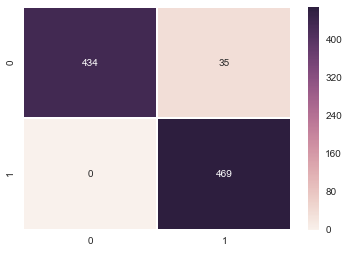

In [43]:
# We train the classifier and evaluate its performance using a k-fold
# http://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold
clf = MultinomialNB()
clf_eval(clf)

In [6]:
import pandas as pd
list(pd.read_excel('descriptive_words.xls')['SIC3'])


[10,
 11,
 13,
 16,
 17,
 18,
 19,
 20,
 21,
 24,
 25,
 27,
 29,
 70,
 71,
 72,
 74,
 75,
 76,
 78,
 80,
 81,
 83,
 85,
 90,
 91,
 92,
 97,
 100,
 101,
 102,
 103,
 104,
 106,
 108,
 109,
 120,
 122,
 123,
 124,
 130,
 131,
 132,
 138,
 140,
 141,
 142,
 144,
 145,
 147,
 148,
 149,
 150,
 152,
 153,
 154,
 160,
 161,
 162,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 249,
 250,
 251,
 252,
 253,
 254,
 259,
 260,
 261,
 262,
 263,
 265,
 267,
 270,
 271,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 287,
 289,
 290,
 291,
 295,
 299,
 300,
 301,
 302,
 305,
 306,
 308,
 310,
 311,
 313,
 314,
 315,
 316,
 317,
 319,
 320,
 321,
 322,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 3

In [8]:
int(132/10)

13

More results :


C %

581 82%